### Imports

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go


In [47]:
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize

In [3]:
from constants import FEATURE_COLUMNS, FEATURE_GASES, TARGET_COLUMNS, FEATURE_GASES_MASS, TARGET_COLUMNS_MASS

from metrics import mean_absolute_percentage_error
from load_data import load_data
from nan_processsing import process_na
from modelling import plot_fitted_values, train_regression
from submission import create_submission

### Load data

In [4]:
train_features = pd.read_csv('data/train_features.csv')
train_targets = pd.read_csv('data/train_targets.csv')

test_features = pd.read_csv('data/test_features.csv')

In [5]:
train_features, train_targets, test_features = load_data()

### EDA

In [6]:
train_features.head()

timestamp     A_rate  A_CH4  A_C2H6  A_C3H8  A_iC4H10  A_nC4H10  \
0 2020-01-01 00:00:00  70.855017    NaN     NaN     NaN       NaN       NaN   
1 2020-01-01 00:30:00  70.826582    NaN     NaN     NaN       NaN       NaN   
2 2020-01-01 01:00:00  70.809637    NaN     NaN     NaN       NaN       NaN   
3 2020-01-01 01:30:00  69.994748    NaN     NaN     NaN       NaN       NaN   
4 2020-01-01 02:00:00  70.072762    NaN     NaN     NaN       NaN       NaN   

   A_iC5H12  A_nC5H12  A_C6H14     B_rate  
0       NaN       NaN      NaN  71.982789  
1       NaN       NaN      NaN  71.965098  
2       NaN       NaN      NaN  71.867409  
3       NaN       NaN      NaN  71.839126  
4       NaN       NaN      NaN  71.336921

In [7]:
train_features.tail()

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
5803 2020-04-30 21:30:00  72.009730  0.284151  4.936343  35.758852  16.473834   
5804 2020-04-30 22:00:00  71.854180  0.282501  4.960453  35.877193  16.448487   
5805 2020-04-30 22:30:00  71.783273  0.277686  5.013878  36.271557  16.500147   
5806 2020-04-30 23:00:00  71.717743  0.271106  5.080144  36.616673  16.559533   
5807 2020-04-30 23:30:00  71.730325  0.265635  5.069165  36.602453  16.649167   

       A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
5803  24.318968  6.069360  5.527463  6.577563  74.183355  
5804  24.074193  5.981357  5.407256  6.915378  74.213066  
5805  24.010123  5.829363  5.160329  6.884173  74.144367  
5806  24.008848  5.750492  5.017941  6.642076  74.320575  
5807  24.150503  5.752792  4.997528  6.459137  74.327170

In [8]:
train_targets.head()

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0 2020-01-01 00:00:00  4.561979  39.015486  17.250740  24.301793
1 2020-01-01 00:30:00  4.550741  39.048915  17.229506  24.257461
2 2020-01-01 01:00:00  4.506793  38.766378  17.171621  24.236298
3 2020-01-01 01:30:00  4.584963  39.069360  17.218521  24.149843
4 2020-01-01 02:00:00  4.607483  38.817579  17.108668  24.049510

In [9]:
test_features.tail()

timestamp     A_rate     A_CH4    A_C2H6     A_C3H8   A_iC4H10  \
3979 2020-07-22 21:30:00  72.600912  0.120985  4.328092  40.875930  17.741460   
3980 2020-07-22 22:00:00  72.107049  0.110734  4.013567  38.871418  17.449352   
3981 2020-07-22 22:30:00  71.805799  0.111535  4.041506  39.794323  17.635380   
3982 2020-07-22 23:00:00  72.112046  0.119362  4.131432  40.461503  17.758833   
3983 2020-07-22 23:30:00  72.941085  0.122393  4.207615  40.957330  17.772225   

       A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
3979  24.098520  4.469224  3.619095  4.686205  75.486026  
3980  24.049532  4.770699  3.988215  6.689777  75.370451  
3981  24.169473  4.613603  3.790651  5.785216  74.985878  
3982  24.211013  4.504242  3.657459  5.094626  74.766867  
3983  24.088445  4.387957  3.536302  4.863965  74.804667

#### Series plotting

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_targets['timestamp'], y=train_targets["B_C3H8"]))
fig.add_trace(go.Scatter(x=train_targets['timestamp'], y=train_targets["B_iC4H10"]))
fig.show()

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_features['timestamp'], y=train_features["A_rate"]))
fig.add_trace(go.Scatter(x=train_features['timestamp'], y=train_features["B_rate"]))
fig.show()

In [10]:
def plot_series(df, layout=None, figsize=(15,15)):
    df.plot(kind='line', subplots=True, grid=True, layout=layout, sharex=True, figsize=figsize)

In [13]:
# plot_series(train_features[FEATURE_COLUMNS], layout=(5,2))

In [14]:
# plot_series(test_features[FEATURE_COLUMNS], layout=(5,2))

In [15]:
# plot_series(train_targets[TARGET_COLUMNS], layout=(2,2), figsize=(15, 7))

#### Train data single x axis

In [16]:
# train_df = pd.concat([train_targets, train_features], axis=1, sort=False)
# plot_series(train_df[TARGET_COLUMNS + FEATURE_COLUMNS], figsize=(15, 20))

#### Rates visual comparison

In [17]:
# plot_series(train_features[['A_rate', 'B_rate']], figsize=(15,5))

In [18]:
# plot_series(test_features[['A_rate', 'B_rate']], figsize=(15,5))

#### Diff of rates

In [19]:
# plot_series(train_features[['A_rate', 'B_rate']].apply(lambda x: x[0]-x[1], axis=1), figsize=(15,3))

In [20]:
# plot_series(test_features[['A_rate', 'B_rate']].apply(lambda x: x[0]-x[1], axis=1), figsize=(15,3))

#### Total compaund of gases

In [21]:
# plot_series(train_features[FEATURE_GASES].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

In [22]:
# plot_series(test_features[FEATURE_GASES].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

In [23]:
# plot_series(train_targets[TARGET_COLUMNS].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

In [11]:
def show_feature_gas_missmatch(df, delta=1):
    gases_sum_df = df[FEATURE_GASES].apply(lambda x: x.sum(), axis=1)
    print('Missmatch, %')
    print(gases_sum_df[(gases_sum_df < 100-delta) & (gases_sum_df > delta)])
    print('\n')
    print('Missmatch points')
    print(df[(gases_sum_df < 100-delta) & (gases_sum_df > delta)])

In [12]:
show_feature_gas_missmatch(train_features)

Missmatch, %
30    83.284430
88    83.281805
dtype: float64


Missmatch points
             timestamp     A_rate     A_CH4   A_C2H6     A_C3H8   A_iC4H10  \
30 2020-01-01 15:00:00  70.825458  0.107138  4.17248  33.986153  14.468455   
88 2020-01-02 20:00:00  71.763913  0.109018  4.47591  36.520668  14.133945   

     A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
30  19.601260  3.508229  3.442494  3.998220  69.986659  
88  18.655932  3.033678  2.954645  3.398009  72.871169  


In [13]:
show_feature_gas_missmatch(test_features)

Missmatch, %
2350     4.148695
2351     4.167530
2475    93.473273
dtype: float64


Missmatch points
               timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  A_iC4H10  \
2350 2020-06-18 23:00:00        NaN       NaN  4.148695        NaN       NaN   
2351 2020-06-18 23:30:00        NaN       NaN  4.167530        NaN       NaN   
2475 2020-06-21 13:30:00  71.936886  0.005033  0.078523  68.149836  2.007036   

      A_nC4H10  A_iC5H12  A_nC5H12    A_C6H14     B_rate  
2350       NaN       NaN       NaN        NaN  71.394341  
2351       NaN       NaN       NaN        NaN  71.518385  
2475   3.73648  1.316491   1.72344  16.456435  74.206501  


In [14]:
def show_target_gas_missmatch(df, target_sum=85, delta=5):
    gases_sum_df = df[TARGET_COLUMNS].apply(lambda x: x.sum(), axis=1)
    print('Missmatch, %')
    mask = ((gases_sum_df < target_sum-delta) & (gases_sum_df > 0.0)) | (gases_sum_df > target_sum+delta)
    print(gases_sum_df[mask])
    print('\n')
    print('Missmatch points')
    print(df[mask])

In [15]:
show_target_gas_missmatch(train_targets, delta=10)

Missmatch, %
4748     15.514087
4754     15.514087
4760     15.514087
4766     15.514087
4772     15.514087
4778     15.514087
4782     54.315387
4784    104.705157
4790     51.736505
4881     63.719634
dtype: float64


Missmatch points
               timestamp     B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
4748 2020-04-08 22:00:00  15.455240   0.026142   0.012764   0.019941
4754 2020-04-09 01:00:00  15.455240   0.026142   0.012764   0.019941
4760 2020-04-09 04:00:00  15.455240   0.026142   0.012764   0.019941
4766 2020-04-09 07:00:00  15.455240   0.026142   0.012764   0.019941
4772 2020-04-09 10:00:00  15.455240   0.026142   0.012764   0.019941
4778 2020-04-09 13:00:00  15.455240   0.026142   0.012764   0.019941
4782 2020-04-09 15:00:00  54.095680   0.099073   0.046072   0.074563
4784 2020-04-09 16:00:00  46.368060  46.527746   0.039690  11.769661
4790 2020-04-09 19:00:00   4.325312  23.913870  10.111635  13.385687
4881 2020-04-11 16:30:00   3.492313  39.656436   6.269465  14.301420


### Fill NA

- gas NaNs (where all NaN and where not all): 
- rates NaNs
- targets Nans

In [17]:
X_train, y_train, X_test = process_na((train_features, train_targets, test_features))

In [18]:
# plot_series(X_train[FEATURE_COLUMNS], layout=(5,2))

In [82]:
# go from % of components and total rates to masses/rates of components

X_train_processed = X_train.copy()
for gas in FEATURE_GASES:
    X_train_processed[f"{gas}_mass"] = X_train[gas]*X_train['A_rate']/100

y_train_processed = y_train.copy()
for gas in TARGET_COLUMNS:
    y_train_processed[f"{gas}_mass"] = y_train[gas]*X_train['B_rate']/100

X_test_processed = X_test.copy()
for gas in FEATURE_GASES:
    X_test_processed[f"{gas}_mass"] = X_test[gas]*X_test['A_rate']/100


# FEATURES_TO_TRAIN = FEATURE_GASES + TARGET_COLUMNS + TARGET_COLUMNS_MASS + FEATURE_GASES_MASS
VARIABLES_TO_TRAIN = TARGET_COLUMNS_MASS + FEATURE_GASES_MASS
train_df = pd.concat([y_train_processed, X_train_processed], axis=1)[VARIABLES_TO_TRAIN]
train_df = pd.concat([train_df, X_train['timestamp'].dt.strftime('%Y-%m-%d %H:%M')], axis=1) #use string of timestamp to view on scatter plots

test_df = X_test_processed[FEATURE_GASES_MASS]
test_df = pd.concat([test_df, X_test['timestamp'].dt.strftime('%Y-%m-%d %H:%M')], axis=1) #use string of timestamp to view on scatter plots

In [83]:
train_df.corr().style.background_gradient(cmap='coolwarm')

In [84]:
test_df.corr().style.background_gradient(cmap='coolwarm')

In [85]:
fig = px.scatter_matrix(train_df, dimensions=[TARGET_COLUMNS_MASS[1]] + FEATURE_GASES_MASS, width=1200, height=1200, hover_data=["timestamp"])
fig.show()

In [86]:
fig = px.scatter_matrix(train_df, dimensions=TARGET_COLUMNS_MASS, width=1200, height=1200, hover_data=["timestamp"])
fig.show()

In [89]:
fig = go.Figure()

for gas in FEATURE_GASES_MASS:
    fig.add_trace(go.Scatter(x=test_df['timestamp'], y=test_df[gas], name=gas))

fig.add_trace(go.Scatter(x=test_df['timestamp'], y=test_df.drop('timestamp', axis=1).apply(sum, axis=1), name='sum'))

fig.update_layout(
    width=1200,
    height=500,
)

In [107]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_df['timestamp'], y=train_df['A_C2H6_mass'], name='A_C3H8_mass'))
fig.add_trace(go.Scatter(x=train_df['timestamp'], y=train_df['B_C2H6_mass'].shift(-12), name='B_C3H8_mass'))

fig.update_layout(
    width=1200,
    height=500,
)

- delete outliers when some masses near to zero
- delete outliers of dates:
    - 2020-04-08 - 2020-04-11 (maybe not all)
- process test dataset with rolling window to change outliers:
    - detect median on window -> change value of outlier with median
- create lags??? (see A_C2H6_mass and B_C2H6_mass at train)

In [41]:
# 1. модель на этан: линейная либо,
# 2. модель на пропан
# 3. модули на бутаны из модели на пропан (линейно)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    3.2s finished
MAPE=25.484686925396637


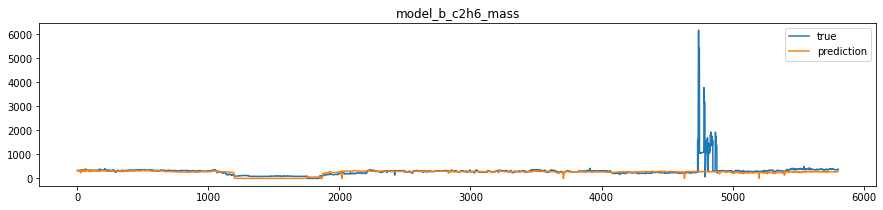

In [42]:
X_masses = processed_df[FEATURE_GASES + FEATURE_GASES_MASS]
y_b_c2h6_mass = processed_df['B_C2H6_mass']

model_b_c2h6_mass = train_regression(X_masses, y_b_c2h6_mass)

b_c2h6_mass_pred = model_b_c2h6_mass.best_estimator_.predict(X_test_processed[FEATURE_GASES + FEATURE_GASES_MASS])
b_c2h6_pred = b_c2h6_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_c2h6_mass.best_estimator_, X_masses, y_b_c2h6_mass, f'model_b_c2h6_mass')

model_pred = model_b_c2h6_mass.best_estimator_.predict(X_masses)
y_true = y_b_c2h6_mass

mape = mean_absolute_percentage_error(y_true.values, model_pred)
print(f"MAPE={mape}")

Fitting 5 folds for each of 34 candidates, totalling 170 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 159 out of 170 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    1.4s finished
MAPE=887.9929759587226


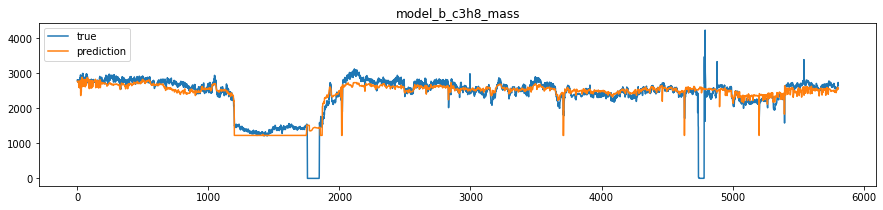

In [43]:
# X_masses = processed_df[['A_C3H8_mass', 'A_CH4_mass']]
X_masses = processed_df[FEATURE_GASES + FEATURE_GASES_MASS]
y_b_c3h8_mass = processed_df['B_C3H8_mass']

model_b_c3h8_mass = train_regression(X_masses, y_b_c3h8_mass)

# b_c3h8_mass_pred = model_b_c3h8_mass.best_estimator_.predict(X_test_processed[['A_C3H8_mass', 'A_CH4_mass']])
b_c3h8_mass_pred = model_b_c3h8_mass.best_estimator_.predict(X_test_processed[FEATURE_GASES + FEATURE_GASES_MASS])
b_c3h8_pred = b_c3h8_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_c3h8_mass.best_estimator_, X_masses, y_b_c3h8_mass, f'model_b_c3h8_mass')

model_pred = model_b_c3h8_mass.best_estimator_.predict(X_masses)
y_true = y_b_c3h8_mass

mape = mean_absolute_percentage_error(y_true, model_pred)
print(f"MAPE={mape}")

Fitting 5 folds for each of 34 candidates, totalling 170 fits
MAPE=32.373824212266804[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.1s finished



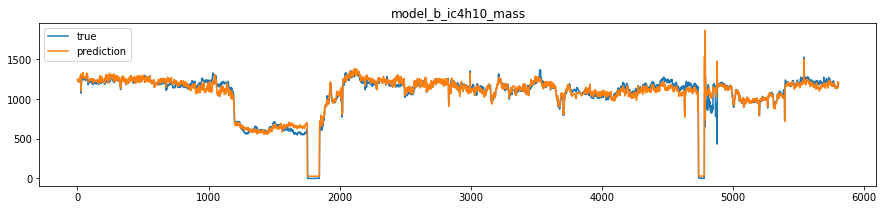

In [44]:
X_masses = y_train_processed['B_C3H8_mass']
y_b_ic4h10_mass = y_train_processed['B_iC4H10_mass']

model_b_ic4h10_mass = train_regression(X_masses.values.reshape(-1,1), y_b_ic4h10_mass)

b_ic4h10_mass_pred = model_b_ic4h10_mass.best_estimator_.predict(b_c3h8_mass_pred.reshape(-1,1))
b_ic4h10_pred = b_ic4h10_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_ic4h10_mass.best_estimator_, X_masses.values.reshape(-1,1), y_b_ic4h10_mass, f'model_b_ic4h10_mass')

model_pred = model_b_ic4h10_mass.best_estimator_.predict(X_masses.values.reshape(-1,1))
y_true = y_b_ic4h10_mass

mape = mean_absolute_percentage_error(y_true, model_pred)
print(f"MAPE={mape}")

Fitting 5 folds for each of 34 candidates, totalling 170 fits
MAPE=78.56653203394387
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    0.0s finished


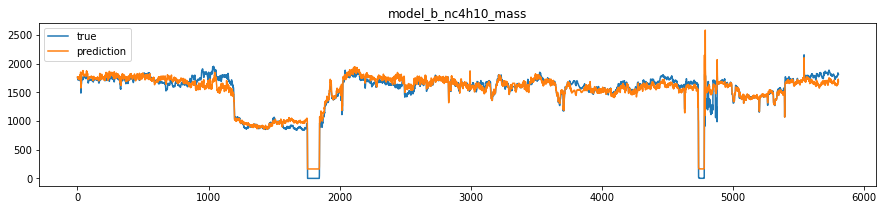

In [45]:
X_masses = y_train_processed['B_C3H8_mass']
y_b_nc4h10_mass = y_train_processed['B_nC4H10_mass']

model_b_nc4h10_mass = train_regression(X_masses.values.reshape(-1,1), y_b_nc4h10_mass)

b_nc4h10_mass_pred = model_b_nc4h10_mass.best_estimator_.predict(b_c3h8_mass_pred.reshape(-1,1))
b_nc4h10_pred = b_nc4h10_mass_pred/X_test_processed['B_rate']

plot_fitted_values(model_b_nc4h10_mass.best_estimator_, X_masses.values.reshape(-1,1), y_b_nc4h10_mass, f'model_b_nc4h10_mass')

model_pred = model_b_nc4h10_mass.best_estimator_.predict(X_masses.values.reshape(-1,1))
y_true = y_b_nc4h10_mass

mape = mean_absolute_percentage_error(y_true, model_pred)
print(f"MAPE={mape}")

In [46]:
y_preds = [s.values for s in [b_c2h6_pred, b_c3h8_pred, b_ic4h10_pred, b_nc4h10_pred]]
sub = create_submission(X_test["timestamp"], y_preds)

In [47]:
# def window_func(x):
#     if abs(x.iloc[-1] - x.mean()) > x.std():
#         return np.median(x)
    
#     return x.iloc[-1]

# y_preds = [s.rolling(30, min_periods=1).apply(window_func).values for s in [b_c2h6_pred, b_c3h8_pred, b_ic4h10_pred, b_nc4h10_pred]]
# sub = create_submission(X_test["timestamp"], y_preds)

In [42]:
sub

timestamp    B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
0    2020-05-01 00:00:00  5.258772  35.278747  15.654723  22.350059
1    2020-05-01 00:30:00  5.234692  35.385754  15.702019  22.417453
2    2020-05-01 01:00:00  4.988575  35.549443  15.772747  22.517106
3    2020-05-01 01:30:00  5.034604  35.665691  15.822416  22.586686
4    2020-05-01 02:00:00  5.132747  35.690999  15.833643  22.602714
...                  ...       ...        ...        ...        ...
3979 2020-07-22 21:30:00  3.808505  37.441091  16.534396  23.550518
3980 2020-07-22 22:00:00  5.228606  35.745473  15.833145  22.584875
3981 2020-07-22 22:30:00  3.384105  37.507984  16.568896  23.603118
3982 2020-07-22 23:00:00  3.331541  39.378747  17.347295  24.678507
3983 2020-07-22 23:30:00  3.713938  38.843465  17.124910  24.371524

[3984 rows x 5 columns]

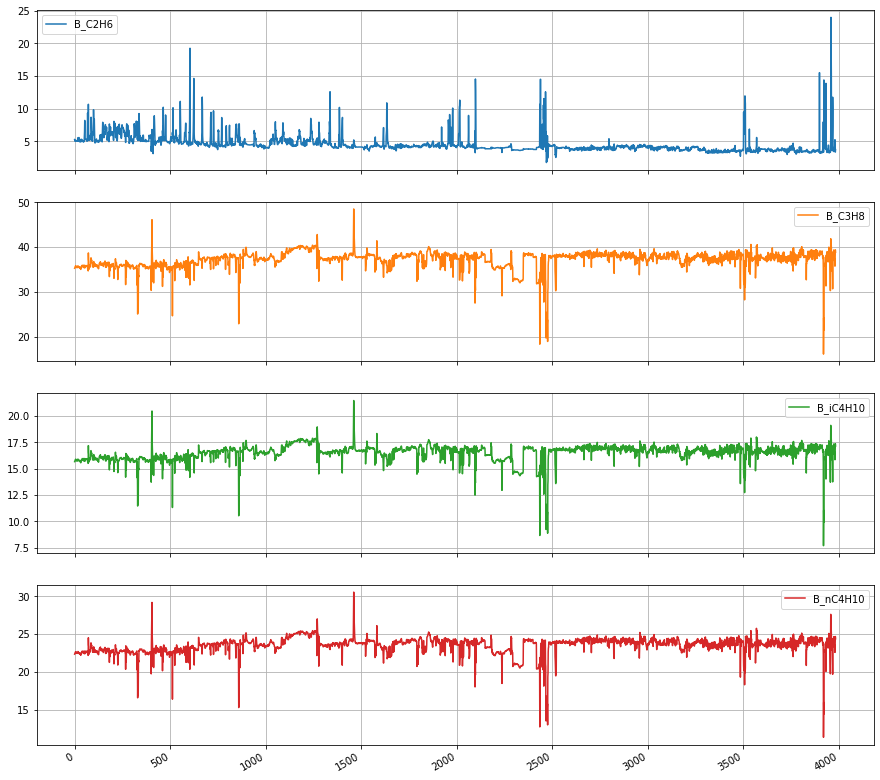

In [43]:
plot_series(sub[TARGET_COLUMNS])

In [56]:
sub.to_csv(f'submission.csv', index=False)